# Piecewise cylindrical CWS optimization

A notebook to run a shape + current optimization for a given plasma configuration

- Define the cost
- Set up the coil factory
- Set up the optimizer
- Run the optimization

In [1]:
%gui qt

from mayavi import mlab

from stellacode.costs import EMCost
from stellacode.surface import IntegrationParams
from stellacode.costs import (
    AggregateCost,
    DistanceCost,
    PoloidalCurrentCost,
    CurrentCtrCost,
)
from stellacode.costs.utils import Constraint

from stellacode.surface import WrappedCoil,FourierSurfaceFactory
from stellacode.optimizer import Optimizer
from stellacode.tools.plots import plot_CWS_LCFS, plot_cross_sections


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Load the W7-X plasma configuration

In [2]:
from stellacode.definitions import w7x_plasma
plasma_config = w7x_plasma

In [3]:
n_harmonics_phi = 16
n_harmonics_u = 4
n_harmonics_v = 4
factor = 4
rotate_diff_current = 1  # num_cyl
make_joints = False  # oblique cut to make joints btw cylinders

lamb = 1e-27
train_currents = True
currentit = 1e8

maxiter = 1
optim_method = "L-BFGS-B"

In [4]:
integration_par = IntegrationParams(
    num_points_u=n_harmonics_u * factor, num_points_v=n_harmonics_v * factor)
Sp = FourierSurfaceFactory.from_file(
    plasma_config.path_plasma, integration_par=integration_par)

In [5]:
costs = []

Constraint related to the magnetic field regression

In [6]:
em_cost = EMCost.from_plasma_config(
    lamb=1e-30,
    plasma_config=plasma_config,
    integration_par=integration_par,
    train_currents=True
)
costs.append(em_cost)

Constraint on the distance between LCFS and coil

In [7]:
distance = DistanceCost(
    Sp=em_cost.Sp,
    constraint=Constraint(
        limit=em_cost.Sp.get_minor_radius(),
        distance=0.03,
        minimum=True,
        method="quadratic"
    ),
)
costs.append(distance)

Add a limit on the current intensity

In [8]:
current_ctr = CurrentCtrCost(
    constraint=Constraint(
        limit=currentit,
        distance=0.3*currentit,
        minimum=False,
        method="quadratic"
    )
)
costs.append(current_ctr)

Add a constraint to avoid negative poloidal currents

In [9]:
pol_curr_ctr = PoloidalCurrentCost(
    Sp=em_cost.Sp, constraint=Constraint(
        limit=0, distance=1e6, minimum=True, method="quadratic")
)
costs.append(pol_curr_ctr)

Sum of all these costs

In [10]:
agg_cost = AggregateCost(
    costs=costs
)

Definition of the coil factory.

In [11]:
coil_factory = WrappedCoil.from_plasma(
    surf_plasma=em_cost.Sp,
    surf_type="cylindrical",
    make_joints=make_joints,
    rotate_diff_current=rotate_diff_current,
    n_harmonics=n_harmonics_phi,  # Number of harmonics in the current fourier expansion
    factor=factor,  # The number of points on the grid is n_harmonics * factor
)

Parameters that will be optimized :

In [12]:
coil_factory.get_trainable_params()

{'0.fourier_coeffs': Array([[0., 0.]], dtype=float32),
 '0.axis_angle': 0.0,
 '0.radius': Array(1.1370535, dtype=float32),
 '0.distance': 5.5,
 '1.0.phi_mn': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

Definition of the optimizer

In [13]:
opt = Optimizer.from_cost(
    agg_cost,
    coil_factory,
    method=optim_method,  # Quasi-Newton method very good for non constrained optimization
    kwargs=dict(
        options={"disp": True, "maxiter": maxiter},
    ),
    save_res=True,
    output_folder_name="../outputs/"
)

Parameters before optimization:

In [14]:
opt.init_param

{'0.fourier_coeffs': Array([[0., 0.]], dtype=float32),
 '0.axis_angle': 0.0,
 '0.radius': Array(1.1370535, dtype=float32),
 '0.distance': 5.5,
 '1.0.phi_mn': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

Run the optimization

In [15]:
cost, metrics, results, optimized_params = opt.optimize()
print(metrics)

max_deltaB_normal: 2.2153429985046387, deltaB_B_L2: 168.43385314941406, deltaB_B_max: 89.27053833007812, cost_B: 41.26416015625, em_cost: 41.26416015625, max_j: 2455346.75, min_distance: 0.037626687437295914, mean_min_distance: 5.2765374183654785, max_distance: 13.349851608276367, mean_max_distance: 9.576884269714355, cost_distance: 205.67318725585938, cost_j_ctr: 0.0, cost_ju_ctr: 4962466.0, max_ju: -15566239.0, min_ju: -15566239.0, total_cost: 4962713.0, 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.96271D+06    |proj g|=  2.05559D+03


 This problem is unconstrained.


max_deltaB_normal: 1561431.5, deltaB_B_L2: 178.66644287109375, deltaB_B_max: 244.0365447998047, cost_B: 2441379.75, em_cost: 2441379.75, max_j: 4914373632.0, min_distance: 0.01715952344238758, mean_min_distance: 5.260852813720703, max_distance: 13.30969524383545, mean_max_distance: 9.537663459777832, cost_distance: 135.40550231933594, cost_j_ctr: 0.0, cost_ju_ctr: 29514174464.0, max_ju: 23322550272.0, min_ju: -18950172672.0, total_cost: 29516615680.0, 
max_deltaB_normal: 2.2150168418884277, deltaB_B_L2: 140.2462158203125, deltaB_B_max: 111.25418853759766, cost_B: 41.2611198425293, em_cost: 41.2611198425293, max_j: 2456023.5, min_distance: 0.037626687437295914, mean_min_distance: 5.2765374183654785, max_distance: 13.349851608276367, mean_max_distance: 9.576884269714355, cost_distance: 205.67318725585938, cost_j_ctr: 0.0, cost_ju_ctr: 4962464.5, max_ju: -15560950.0, min_ju: -15570530.0, total_cost: 4962711.5, 
max_deltaB_normal: 2.215188980102539, deltaB_B_L2: 403.8839111328125, deltaB_B


At iterate    1    f=  4.96271D+06    |proj g|=  4.66426D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  600      1      6      1     0     0   4.664D+03   4.963D+06
  F =   4962712.0000000000     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
{'max_deltaB_normal': Array(2.2151299, dtype=float32), 'deltaB_B_L2': Array(78.93572, dtype=float32), 'deltaB_B_max': Array(48.21809, dtype=float32), 'cost_B': Array(41.26217, dtype=float32), 'em_cost': Array(41.26217, dtype=float32), 'max_j': Array(2455787., dtype=float32), 'min_distance': Array(0.03762669, dtype=float32), 'mean_min_distance': Array(5.276537

Optimized parameters :

In [16]:
coil_factory.get_trainable_params()

{'0.fourier_coeffs': array([[-5.51600288e-09,  4.15265662e-11]]),
 '0.axis_angle': array(-9.18613615e-10),
 '0.radius': array(1.1370535),
 '0.distance': array(5.5),
 '1.0.phi_mn': array([-5.89035719e-10,  5.19366094e-09, -8.30174147e-10,  3.37498824e-09,
        -5.42441993e-10, -3.20872330e-09, -8.91858687e-10, -1.94573943e-09,
        -2.66829536e-09,  6.01648285e-09, -1.11635785e-09,  1.41822534e-08,
         1.84192204e-09,  9.23356005e-10,  5.24586880e-09, -1.09814570e-08,
        -2.36825148e-10,  1.39965512e-08,  7.63558319e-10, -1.08253306e-08,
         7.10114478e-11, -7.48786944e-09, -3.51670443e-10, -7.78315871e-09,
        -1.78118115e-09, -1.87821809e-09, -2.67075128e-09,  6.41841621e-09,
        -1.03043206e-09,  7.03924440e-09,  1.83842172e-09, -2.35227978e-09,
         1.24078026e-09, -1.01692765e-08, -1.47434110e-08, -1.20750215e-09,
         1.54784873e-08, -6.30777038e-10,  1.45594730e-08,  1.81648727e-10,
         1.41751843e-08,  2.24612367e-09,  5.44078474e-09,  3

/!\ the parameters of the coil factory were changed in place during the optimization

In [17]:
coil_surface = coil_factory().get_coil(results.phi_mn_wnet_cur)

In [18]:
if make_joints:
    cut_tor = None
else:
    cut_tor = n_harmonics_phi * factor // rotate_diff_current

3D plots

In [19]:
coil_surface.plot(
    vector_field=coil_surface.j_3d,
    reduce_res=1,
    quiver_kwargs=dict(
        line_width=2,
        scale_factor=0.08,
    ),
    cut_tor=cut_tor,
)

In [ ]:
fig = coil_surface.plotly_plot(cut_tor=cut_tor, colormap="Reds")
fig_eq = Sp().plotly_plot(colormap="Blues", nfp=5)
fig.add_traces(fig_eq.data)
fig.show()

2D plots

In [ ]:
plot_CWS_LCFS(coil_surface, em_cost.Sp, n_cyl=rotate_diff_current)

<PolarAxes: >

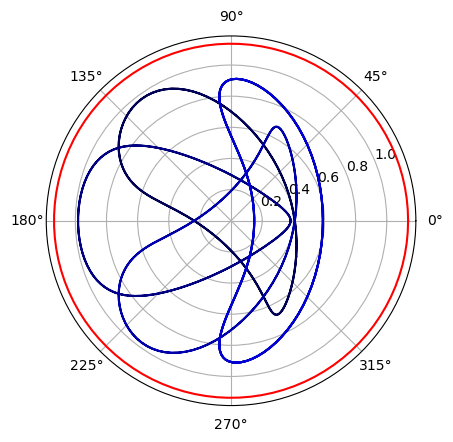

In [22]:
plot_cross_sections(coil_factory, Sp)